<a href="https://colab.research.google.com/github/Nafiseh-Izadyar/CSC581B-/blob/main/CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction to Deep Learning for Image Classification - CSC 581B - A01**
*Nafiseh* *Izadyar*

# Objective: Implementing a standard CNN to classify CIFAR-100.
The code is implemented using Pytorch

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import time

# Loading dataset
augment = True
# batch Size
batch_size = 128
# num_workers
num_workers = 4

if augment == True:
  transform = transforms.Compose(
      [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomRotation(15),
        transforms.RandomCrop(32,4),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  )

  test_transform = transforms.Compose(
      [
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  )
else:
  transform = transforms.Compose(
      [
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  )
  test_transform = transforms.Compose(
      [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  )


# loading train and Validation Set
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
print('Train Size:', len(trainset))

# Validation Set
torch.manual_seed(32)
validation_size = 10000
train_size = len(trainset) - validation_size
temp = train_size

train, validation = torch.utils.data.random_split(trainset,[train_size,validation_size]) 

trainloader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = num_workers)
validationloader = torch.utils.data.DataLoader(validation, batch_size = batch_size, num_workers = num_workers)

# loading test set
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
print('Test Size: ',len(testset))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers = num_workers)

print('Classes: ')
print(trainset.classes)

print('Done!')


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Train Size: 50000
Files already downloaded and verified
Test Size:  10000
Classes: 
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 

Displaying some images from train set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


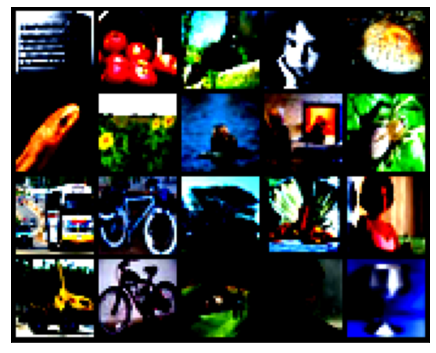

In [3]:
from torchvision.utils import make_grid
def show_data(train):
    for batch in train:
        images,labels = batch
        fig, ax = plt.subplots(figsize=(7.5,7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20],nrow=5).permute(1,2,0))
        break
show_data(trainloader)

Moving to the GPU for faster computations.

In [4]:
if torch.cuda.is_available():
  print('GPU is available')
  device = 'cuda'
else:
  print('No GPU')
  device = 'cpu'

No GPU


Defining some required functions

In [5]:
def accuracy(output,label):
  _, preds = torch.max(output, dim=1)
  return torch.tensor(torch.sum(preds == label).item() / len(preds))

def ploting(printloss,validation_loss,printval,printtrain,learning_rate):
  # plot loss
  plt.plot(printloss,'-o',label='train')
  plt.plot(validation_loss,'-o',label='validation')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('loss')
  plt.legend(loc ="upper left")
  plt.figure()

  # plott accuracy on validation set
  plt.plot(printval,'-o',label = 'validation')
  plt.plot(printtrain,'-o',label='train')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy of validation set in different epochs')
  plt.legend(loc ="upper left")
  plt.figure()

  # plot learning rate
  plt.plot(learning_rate,'-o')
  plt.xlabel('Epoch')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate Decay')

def testModel(model,test):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# For ResNet Model
def convolutionbl(inp, out, pooling = False):
  layers = [
            nn.Conv2d(inp, out, kernel_size = 3, padding = 1), 
            nn.BatchNorm2d(out), 
            nn.ReLU(inplace=True)
            ]
  if pooling == True:
       layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)


## **Logistic Regression**
The first simple linear model

In [7]:
class logregression(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(32 * 32 * 3,100)
  
  def forward(self,x):
    x = torch.flatten(x,1)
    x = self.fc(x)
    return x
    
lg = logregression()
lg.to(device)

logregression(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
)

**Loss function:** Cross Entropy, **Optimization:** SGD

For better training, the momentum and weight decay are also applied to the model, besides the learning rate is being adjusted. Each time the error plateau it will be reduced by a factor of 10.

In [8]:
# Defining the cretierian, optimizer, and learning rate reduction policy

lgcriterian = nn.CrossEntropyLoss()
lgoptim = optim.Adam(lg.parameters(),lr=0.01,weight_decay=1e-4)

# Learning rate policy

#schedualer = optim.lr_scheduler.ReduceLROnPlateau(lgoptim,'min')
schedualer = optim.lr_scheduler.MultiStepLR(lgoptim,[10,20])
#schedualer = torch.optim.lr_scheduler.CyclicLR(lgoptim, base_lr=0.01, max_lr=0.1)

# lmbda = lambda epoch: 0.95
# schedualer = optim.lr_scheduler.MultiplicativeLR(lgoptim, lr_lambda=lmbda)


# Training the Logistic regression model

In [9]:

torch.cuda.empty_cache()
# Tracking the training time
a = time.time()

# tracking loss
total_loss = []

# tracking train and validation accuracy
val_acc = []
train_acc = []
validation_loss = []

# tracking the learning-rate
learning_rate = []

# train for number of epochs
epochs = 15
for iter in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader,0):

    inputs, labels = data[0].to(device), data[1].to(device)
    lgoptim.zero_grad()
    outputs = lg(inputs)

    # calculating the loss
    loss = lgcriterian(outputs,labels)
    loss.backward()
    lgoptim.step()

    lr = lgoptim.param_groups[0]["lr"]

    running_loss += loss.item()

    if i % 313 == 312:
      print('[%d, %5d] loss: %.3f' % (iter + 1, i + 1, running_loss / 313))
      total_loss.append(running_loss / 313)
      running_loss = 0.0
  
  learning_rate.append(lr)

  # keeping track of train acc
  acc_train = accuracy(outputs,labels)
  train_acc.append(acc_train)

  # Validation
  val_loss = []

  for j, valdata in enumerate(validationloader,0):
    valin, vallabel = valdata[0].to(device), valdata[1].to(device)
    valout = lg(valin) 
    val_loss.append(lgcriterian(valout,vallabel))
    acc = accuracy(valout,vallabel)
  
  epoch_loss = torch.stack(val_loss).mean()
  validation_loss.append(epoch_loss)
  print('[%d, %5d] val loss: %.3f' % (iter + 1, i + 1, epoch_loss))
  print('[%d, %5d] val accuracy: %.3f' % (iter + 1, i + 1, acc * 100))
  val_acc.append(acc)

  schedualer.step()
  

b = time.time()
print(b-a)

[1,   313] loss: 19.483
[1,   313] val loss: 20.095
[1,   313] val accuracy: 12.500
[2,   313] loss: 19.867
[2,   313] val loss: 20.283
[2,   313] val accuracy: 6.250
[3,   313] loss: 20.114
[3,   313] val loss: 20.103
[3,   313] val accuracy: 6.250
[4,   313] loss: 20.386
[4,   313] val loss: 20.641
[4,   313] val accuracy: 6.250
[5,   313] loss: 20.374
[5,   313] val loss: 20.569
[5,   313] val accuracy: 12.500
[6,   313] loss: 20.352
[6,   313] val loss: 20.742
[6,   313] val accuracy: 0.000
[7,   313] loss: 20.337
[7,   313] val loss: 20.686
[7,   313] val accuracy: 12.500
[8,   313] loss: 20.373
[8,   313] val loss: 20.764
[8,   313] val accuracy: 6.250
[9,   313] loss: 20.397
[9,   313] val loss: 20.304
[9,   313] val accuracy: 0.000
[10,   313] loss: 20.515
[10,   313] val loss: 20.612
[10,   313] val accuracy: 0.000
[11,   313] loss: 10.001
[11,   313] val loss: 8.039
[11,   313] val accuracy: 6.250
[12,   313] loss: 7.271
[12,   313] val loss: 6.958
[12,   313] val accuracy: 0

plotting the loss of the training set and the accuracy on the validation set

Accuracy of the network on the 10000 test images: 7 %


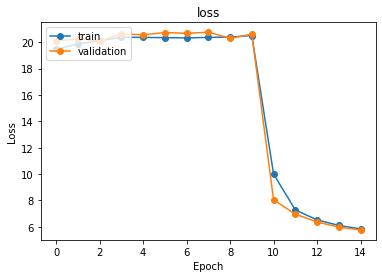

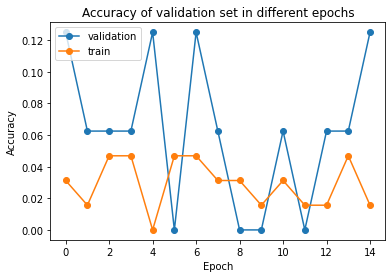

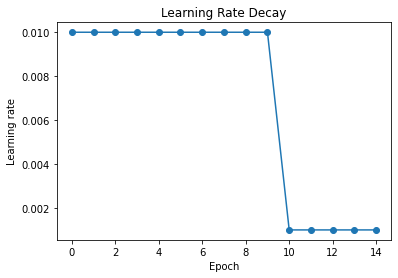

In [10]:
ploting(total_loss,validation_loss,val_acc,train_acc,learning_rate)
testModel(lg,testloader)



## **LeNet**

In [5]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    # outpu: 28 * 28 * 6
    self.max1 = nn.MaxPool2d(2,2)
    # output: 14 * 14 * 6
    self.conv2 = nn.Conv2d(6,16,5)
    # 10 * 10 * 16
    self.max2 = nn.MaxPool2d(2,2)
    # 5 * 5 * 16
    self.fc1 = nn.Linear(5*5*16,200)
    self.fc2 = nn.Linear(200,100)

  def forward(self,x):
    x = self.max1(F.sigmoid(self.conv1(x)))
    x = self.max2(F.sigmoid(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.sigmoid(self.fc1(x))
    x = self.fc2(x)
    return x

leNet = LeNet()
leNet.to(device)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
)

In [7]:
leNetcriterion = nn.CrossEntropyLoss()
leNetoptimizer = optim.Adam(leNet.parameters(),lr = 0.1,weight_decay=1e-4)
#leNetschedualer = optim.lr_scheduler.ReduceLROnPlateau(leNetoptimizer,'min')
#leNetschedualer = optim.lr_scheduler.MultiStepLR(leNetoptimizer,[5,20])
#leNetschedualer = torch.optim.lr_scheduler.CyclicLR(leNetoptimizer, base_lr=0.05, max_lr=0.1)

# lmbda = lambda epoch: 0.95
# leNetschedualer = optim.lr_scheduler.MultiplicativeLR(leNetoptimizer, lr_lambda=lmbda)

In [8]:
# Tracking the training time
a = time.time()

# tracking loss
total_loss = []

# tracking train and validation accuracy
val_acc = []
train_acc = []
validation_loss = []

# tracking the learning-rate
learning_rate = []

# train for number of epochs
epochs = 25
for iter in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader,0):

    inputs, labels = data[0].to(device), data[1].to(device)
    leNetoptimizer.zero_grad()
    outputs = leNet(inputs)

    # calculating the loss
    loss = leNetcriterion(outputs,labels)
    loss.backward()
    leNetoptimizer.step()

    lr = leNetoptimizer.param_groups[0]["lr"]

    running_loss += loss.item()

    if i % 313 == 312:
      print('[%d, %5d] loss: %.3f' % (iter + 1, i + 1, running_loss / 313))
      total_loss.append(running_loss / 313)
      running_loss = 0.0
  
  learning_rate.append(lr)

  # keeping track of train acc
  acc_train = accuracy(outputs,labels)
  train_acc.append(acc_train)

  # Validation
  val_loss = []

  for j, valdata in enumerate(validationloader,0):
    valin, vallabel = valdata[0].to(device), valdata[1].to(device)
    valout = leNet(valin) 
    val_loss.append(leNetcriterion(valout,vallabel))
    acc = accuracy(valout,vallabel)
  
  epoch_loss = torch.stack(val_loss).mean()
  validation_loss.append(epoch_loss)
  print('[%d, %5d] val loss: %.3f' % (iter + 1, i + 1, epoch_loss))
  print('[%d, %5d] val accuracy: %.3f' % (iter + 1, i + 1, acc * 100))
  val_acc.append(acc)

  #leNetschedualer.step(epoch_loss)
  #leNetschedualer.step()


b = time.time()
print(b-a)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,    39] loss: 8.991
[1,    78] loss: 5.033
[1,   117] loss: 5.272
[1,   156] loss: 5.804
[1,   195] loss: 5.864
[1,   234] loss: 6.337
[1,   273] loss: 7.350
[1,   312] loss: 6.074
[1,   313] val loss: 5.639
[1,   313] val accuracy: 6.250
[2,    39] loss: 5.847
[2,    78] loss: 5.948
[2,   117] loss: 5.632
[2,   156] loss: 5.878
[2,   195] loss: 7.189
[2,   234] loss: 9.363
[2,   273] loss: 8.193
[2,   312] loss: 6.910
[2,   313] val loss: 7.551
[2,   313] val accuracy: 0.000
[3,    39] loss: 7.328
[3,    78] loss: 7.837
[3,   117] loss: 6.525
[3,   156] loss: 6.624
[3,   195] loss: 6.590
[3,   234] loss: 6.833
[3,   273] loss: 6.385
[3,   312] loss: 7.544
[3,   313] val loss: 10.539
[3,   313] val accuracy: 0.000
[4,    39] loss: 11.879
[4,    78] loss: 14.050
[4,   117] loss: 19.697
[4,   156] loss: 24.661
[4,   195] loss: 18.729
[4,   234] loss: 16.569
[4,   273] loss: 18.025
[4,   312] loss: 14.462
[4,   313] val loss: 11.463
[4,   313] val accuracy: 6.250
[5,    39] loss: 11.87

RuntimeError: ignored

Plotting the results and testing the model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network on the 10000 test images: 8 %


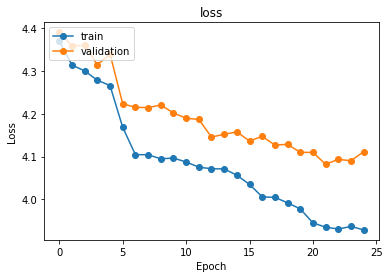

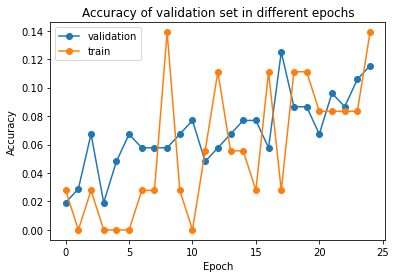

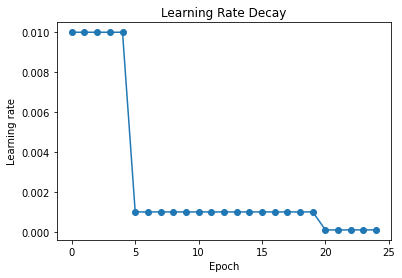

In [ ]:
ploting(total_loss,validation_loss,val_acc,train_acc,learning_rate)
testModel(leNet,testloader)


## **Simple CNN model**

In [6]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,32,3,padding=1)
    # output size = 32 * 32 * 32
    self.conv2 = nn.Conv2d(32,64,3,stride=1,padding=1)
    # output size = 32 * 32 * 64
    self.max1 = nn.MaxPool2d(2,2)
    # output size = 16 * 16 * 64

    self.conv3 = nn.Conv2d(64,128,3,stride=1,padding=1)
    # output size: 16 * 16 * 128
    self.conv4 = nn.Conv2d(128,128,3,stride=1,padding=1)
    # output size: 16 * 16 * 128
    self.max2 = nn.MaxPool2d(2,2)
    # output size: 8 * 8 * 128

    self.conv5 = nn.Conv2d(128,256,3,stride=1,padding=1)
    # output size: 8 * 8 * 256
    self.conv6 = nn.Conv2d(256,256,3,stride=1,padding=1)
    # output size: 8 * 8 * 256
    self.max3 = nn.MaxPool2d(2,2)
    # output size: 4 * 4 * 256

    self.fc1 = nn.Linear(4*4*256,1024)
    #self.fc2 = nn.Linear(1024,512)
    self.fc3 = nn.Linear(1024,100)


  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.max1(F.relu(self.conv2(x)))

    x = F.relu(self.conv3(x))
    x = self.max2(F.relu(self.conv4(x)))

    x = F.relu(self.conv5(x))
    x = self.max3(F.relu(self.conv6(x)))
    
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

cnnNet = SimpleCNN()
cnnNet.to(device)


# output size = 32 * 32 * 32
# output size = 32 * 32 * 64
# output size = 16 * 16 * 64
# output size: 16 * 16 * 128
# output size: 16 * 16 * 128
# output size: 8 * 8 * 128
# output size: 8 * 8 * 256
# output size: 8 * 8 * 256
# output size: 4 * 4 * 256



SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=100, bias=True)
)

In [7]:
simple_criterion = nn.CrossEntropyLoss()
simple_optimizer = optim.SGD(cnnNet.parameters(),lr=0.01,momentum=0.9,weight_decay=1e-4)
#simple_schedualer = optim.lr_scheduler.ReduceLROnPlateau(simple_optimizer,'min')

#simple_schedualer = optim.lr_scheduler.ReduceLROnPlateau(simple_optimizer,'min')
#simple_schedualer = optim.lr_scheduler.MultiStepLR(simple_optimizer,[5,7])
#simple_schedualer = torch.optim.lr_scheduler.CyclicLR(simple_optimizer, base_lr=0.05, max_lr=0.1)

# lmbda = lambda epoch: 0.95
# leNesimple_schedualertschedualer = optim.lr_scheduler.MultiplicativeLR(simple_optimizer, lr_lambda=lmbda)

Training the network

In [8]:
# Tracking the training time
a = time.time()

# tracking loss
total_loss = []

# tracking train and validation accuracy
val_acc = []
train_acc = []
validation_loss = []

# tracking the learning-rate
learning_rate = []

# train for number of epochs
epochs = 10
for iter in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader,0):

    inputs, labels = data[0].to(device), data[1].to(device)
    simple_optimizer.zero_grad()
    outputs = cnnNet(inputs)

    # calculating the loss
    loss = simple_criterion(outputs,labels)
    loss.backward()
    simple_optimizer.step()

    lr = simple_optimizer.param_groups[0]["lr"]

    running_loss += loss.item()

    if i % 313 == 312:
      print('[%d, %5d] loss: %.3f' % (iter + 1, i + 1, running_loss / 313))
      total_loss.append(running_loss / 313)
      running_loss = 0.0
  
  learning_rate.append(lr)

  # keeping track of train acc
  acc_train = accuracy(outputs,labels)
  train_acc.append(acc_train)

  # Validation
  val_loss = []

  # for j, valdata in enumerate(validationloader,0):
  #   valin, vallabel = valdata[0].to(device), valdata[1].to(device)
  #   valout = cnnNet(valin) 
  #   val_loss.append(simple_criterion(valout,vallabel))
  #   acc = accuracy(valout,vallabel)
  
  # epoch_loss = torch.stack(val_loss).mean()
  # validation_loss.append(epoch_loss)
  # print('[%d, %5d] val loss: %.3f' % (iter + 1, i + 1, epoch_loss))
  # print('[%d, %5d] val accuracy: %.3f' % (iter + 1, i + 1, acc * 100))
  # val_acc.append(acc)

  #simple_schedualer.step()
  del inputs,outputs, labels


b = time.time()
print(b-a)

[1,   313] loss: 4.604
[2,   313] loss: 4.327


KeyboardInterrupt: ignored

*Plotting* results and testing the model

Accuracy of the network on the 10000 test images: 26 %


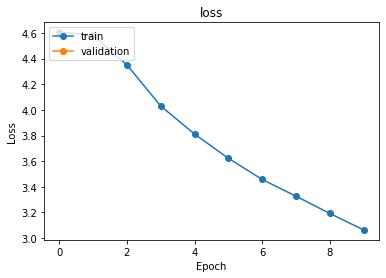

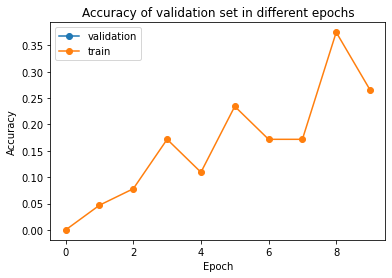

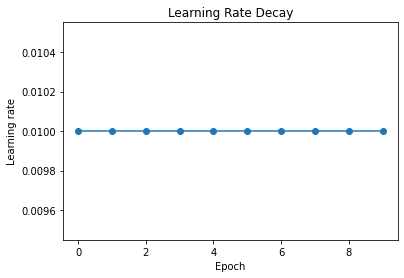

In [7]:
ploting(total_loss,validation_loss,val_acc,train_acc,learning_rate)
testModel(cnnNet,testloader)

## **ResNet**

In [4]:
class ResNet8(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = convolutionbl(3, 64)
        self.conv2 = convolutionbl(64, 128, pooling = True)
        self.res1 = nn.Sequential(convolutionbl(128,128),convolutionbl(128,128))
        
        self.conv3 = convolutionbl(128, 256, pooling = True) 
        self.conv4 = convolutionbl(256, 512, pooling = True)
        self.res2 = nn.Sequential(convolutionbl(512, 512), convolutionbl(512, 512)) 

        self.conv5 = convolutionbl(512, 1028, pooling = True) 
        self.res3 = nn.Sequential(convolutionbl(1028, 1028), convolutionbl(1028, 1028)) 
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Flatten(), 
                                        nn.Linear(1028, 100))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.conv5(x)
        x = self.res3(x) + x
        x = self.classifier(x)
        return x

resNet = ResNet8()
resNet.to(device)

ResNet8(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [5]:
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resNet.parameters(),lr=0.01,weight_decay=1e-3)
#resnet_schedualer = optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer,'min')
#resnet_schedualer = optim.lr_scheduler.MultiStepLR(resnet_optimizer,[5,20])

In [6]:

#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.01, epochs = epochs, steps_per_epoch=len(trainloader))


# Tracking the training time
a = time.time()

# tracking loss
total_loss = []

# tracking train and validation accuracy
val_acc = []
train_acc = []
validation_loss = []

# tracking the learning-rate
learning_rate = []

# train for number of epochs
epochs = 10
for iter in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader,0):

    inputs, labels = data[0].to(device), data[1].to(device)
    resnet_optimizer.zero_grad()
    outputs = resNet(inputs)

    # calculating the loss
    loss = resnet_criterion(outputs,labels)
    loss.backward()
    resnet_optimizer.step()

    lr = resnet_optimizer.param_groups[0]["lr"]

    running_loss += loss.item()

    if i % 313 == 312:
      print('[%d, %5d] loss: %.3f' % (iter + 1, i + 1, running_loss / 313))
      total_loss.append(running_loss / 313)
      running_loss = 0.0
  
  learning_rate.append(lr)

  # keeping track of train acc
  acc_train = accuracy(outputs,labels)
  train_acc.append(acc_train)

  # Validation
  val_loss = []

  # for j, valdata in enumerate(validationloader,0):
  #   valin, vallabel = valdata[0].to(device), valdata[1].to(device)
  #   valout = resNet(valin) 
  #   val_loss.append(resnet_criterion(valout,vallabel))
  #   acc = accuracy(valout,vallabel)
  
  # epoch_loss = torch.stack(val_loss).mean()
  # validation_loss.append(epoch_loss)
  # print('[%d, %5d] val loss: %.3f' % (iter + 1, i + 1, epoch_loss))
  # print('[%d, %5d] val accuracy: %.3f' % (iter + 1, i + 1, acc * 100))
  # val_acc.append(acc)

  #resnet_schedualer.step()


b = time.time()
print(b-a)


    

[1,   313] loss: 5.450
[2,   313] loss: 4.121
[3,   313] loss: 3.855
[4,   313] loss: 3.681
[5,   313] loss: 3.556
[6,   313] loss: 3.466
[7,   313] loss: 3.367
[8,   313] loss: 3.307
[9,   313] loss: 3.245
[10,   313] loss: 3.190
800.6370484828949


Accuracy of the network on the 10000 test images: 20 %


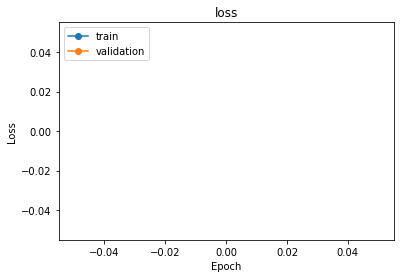

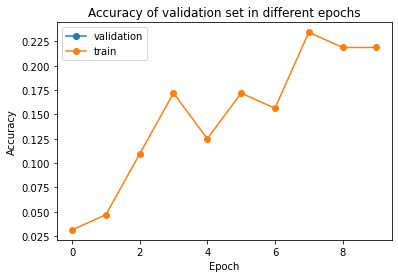

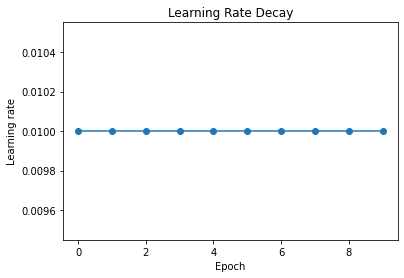

In [8]:
t = []
valloss = []
ploting(valloss,t,val_acc,train_acc,learning_rate)
testModel(resNet,testloader)